In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pickle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import *
import umap
from sknetwork.clustering import Louvain,get_modularity
ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds.pkl")

In [4]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

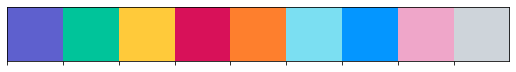

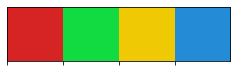

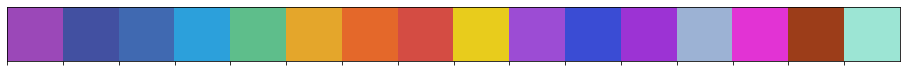

In [5]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.612,	0.3 , 0.834],
                    [0.23,	0.3 , 0.834],
                    [0.612,	0.2 , 0.834],
                    [0.612,	0.7 , 0.834],
                    [0.89,	0.2 , 0.834],
                    [0.612,	0.24 , 0.1],
                    [0.612,	0.9 , 0.834]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

325


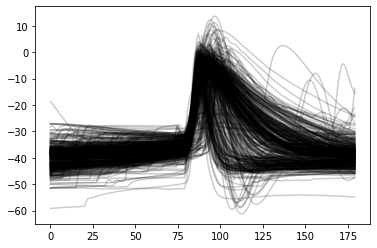

In [6]:
# data_wave_FN = pd.read_pickle('D:/CurrentClamp/all_waveforms_entire.pkl')
data_wave_FN = ephys
data_wave_FN.cond = [i.lower() for i in data_wave_FN.cond]
print(len(set(data_wave_FN.exp_name)))

# data_wave_FN.exp_name = [i[:-3] for i in data_wave_FN.exp_name]
data_wave_FN_acsf = data_wave_FN[data_wave_FN.cond=='acsf'] 
fig = plt.Figure(figsize=[10,10])
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.2)
plt.show()


10


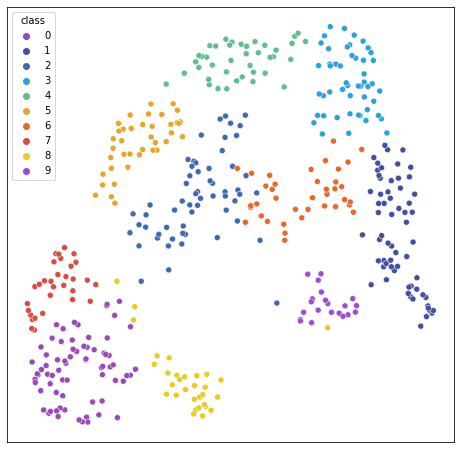

In [7]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )

<ipython-input-8-629bb4451780>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wave_FN_acsf['LV_ID'] = lables_wave


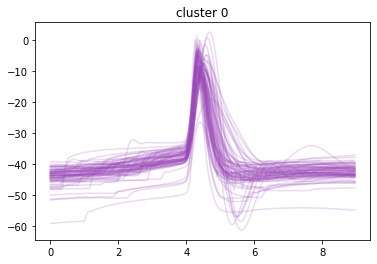

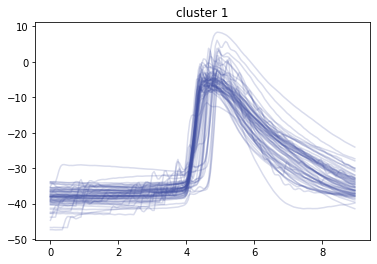

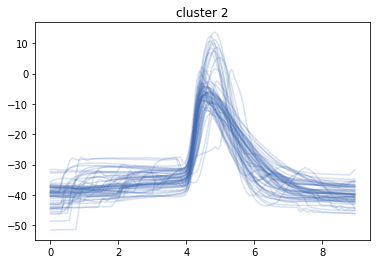

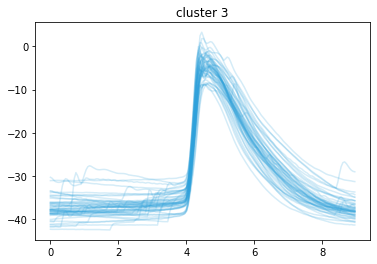

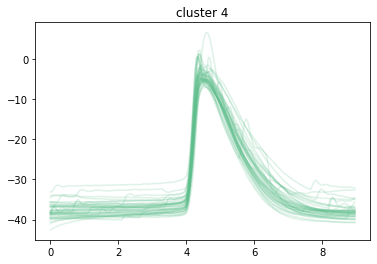

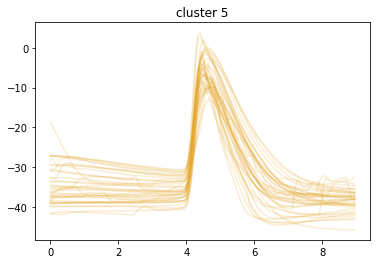

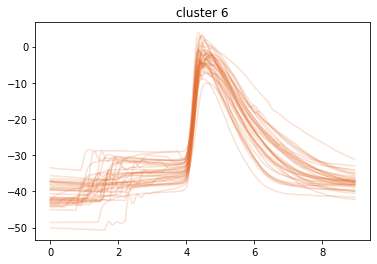

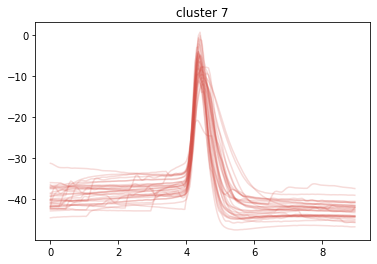

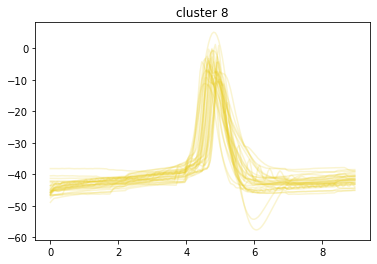

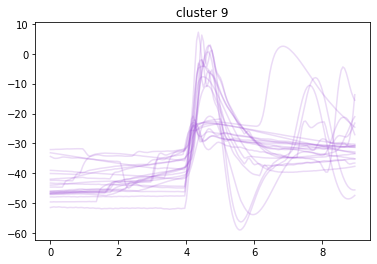

In [8]:
data_wave_FN_acsf['LV_ID'] = lables_wave
# ephys['wave_ID']
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[5,5])
    to_plot = np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,180/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    plt.show()


2


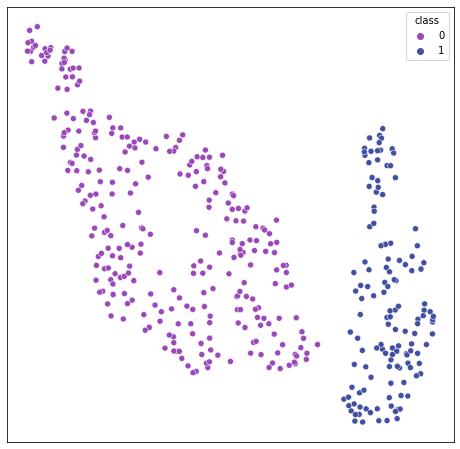

In [9]:
new_wave = data_wave_FN_acsf[data_wave_FN_acsf.LV_ID!=9]

waves_new = normalize(np.vstack(new_wave['waveform']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves_new,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )




<ipython-input-10-abbe12f4491e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_wave['LV_ID'] = lables_wave


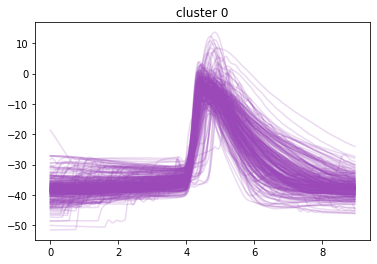

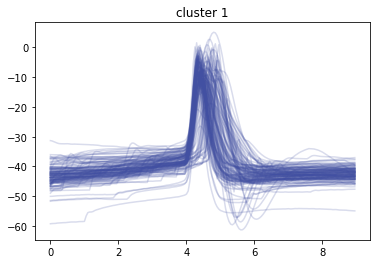

In [10]:
new_wave['LV_ID'] = lables_wave
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.vstack(new_wave[new_wave.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,180/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    plt.show()

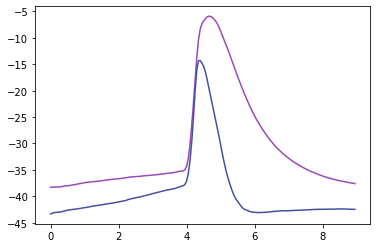

In [11]:
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.mean(np.vstack(new_wave[new_wave.LV_ID==i]['waveform']).T,axis=1)
    plt.plot(np.arange(0,180/20,1/20),to_plot,c=coherence_colors[i],alpha=1)
    # plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    # plt.show()

In [120]:
exps_exc = new_wave[new_wave.LV_ID==0].exp_name
exps_inh = new_wave[new_wave.LV_ID==1].exp_name

df_exc_FN = data_wave_FN[data_wave_FN.exp_name.isin(exps_exc)]
df_inh_FN = data_wave_FN[data_wave_FN.exp_name.isin(exps_inh)]


In [15]:
print(np.unique(df_exc_FN.cond,return_counts=True))
print(np.unique(df_inh_FN.cond,return_counts=True))
pd.DataFrame({'condition':np.unique(df_inh_FN.cond,return_counts=True)[0],'counts':np.unique(df_inh_FN.cond,return_counts=True)[1]})



(array(['acsf', 'agoanta', 'cirazoline', 'd1', 'd1ago', 'd2', 'dop',
       'dopamine', 'm1-ag', 'm1-ago', 'm1-ago+ant', 'm1-ant',
       'm1-ant+ago', 'sag'], dtype=object), array([297,  16,  18,   6,  50,  51,   8,  12,   2,  21,   2,  13,   6,
        13], dtype=int64))
(array(['acsf', 'agoanta', 'cirazoline', 'd1', 'd1ago', 'd2', 'dop',
       'dopa', 'dopamine', 'm1-ag', 'm1-ago', 'm1-ago+ant', 'm1-ant',
       'm1-ant+ago', 'sag'], dtype=object), array([136,  19,  22,  10,  19,  13,  11,   1,   9,   2,  17,   2,  11,
         4,  10], dtype=int64))


,condition,counts
0,acsf,136
1,agoanta,19
2,cirazoline,22
3,d1,10
4,d1ago,19
5,d2,13
6,dop,11
7,dopa,1
8,dopamine,9
9,m1-ag,2


In [114]:
# np.unique(data_wave_FN_acsf.trialnr,return_counts=True)
df_temp_exps  = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==2].exp_name
df_temp = data_wave_FN_acsf[data_wave_FN_acsf.exp_name.isin(df_temp_exps)]
df_temp =df_temp[df_temp.trialnr.isin([0,1])] 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:7.618e-01 t=-3.071e-01


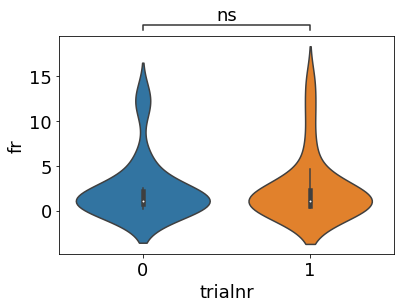

In [115]:
var='fr'
df_temp[var] = np.array(df_temp[var],dtype=np.float32)

order = [0,1]
ax = sns.violinplot(data=df_temp,x='trialnr',y=var,dtype=np.float32)
annot = Annotator(ax, [(0,1)], data=df_temp, x='trialnr', y=var, order=order)
annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()

In [122]:
from statannotations.Annotator import Annotator
def plot_significance(df, drug,var):
    drug = drug
    # exps_drug = df_inh[df_inh.cond.isin(['acsf',drug])].exp_name
    # df_drug = df_inh[df_inh.exp_name.isin(exps_drug)]
    df_drug = df[df.cond.isin(['acsf',drug])]
    # df_drug = df_drug[df_drug.trialnr==0] 
    df_drug.cond = pd.Categorical(df_drug['cond'])
    df_drug[var] = np.array(df_drug[var],dtype=np.float32)

    order = ['acsf',drug]
    ax = sns.violinplot(data=df_drug,x='cond',y=var,dtype=np.float32)
    annot = Annotator(ax, [("acsf", drug)], data=df_drug, x='cond', y=var, order=order)
    annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
    annot.apply_test()
    ax, test_results = annot.annotate()
    plt.show()

In [118]:
all_drug_FN = set(df_exc_FN.cond)
df_exc_FN.columns

Index(['waveform', 'current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'tau', 'exp_name', 'cond', 'trialnr'],
      dtype='object')

<ipython-input-122-0cf6f52ad6f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-122-0cf6f52ad6f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


ValueError: unequal length arrays

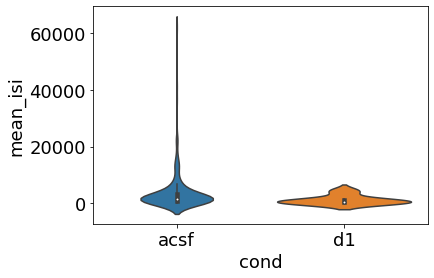

In [123]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
for drug in all_drug_FN:
    if drug !='acsf':
        plot_significance(df_exc_FN,drug,'mean_isi')

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. d1ago: Mann-Whitney-Wilcoxon test two-sided, P_val:3.665e-01 U_stat=1.458e+03


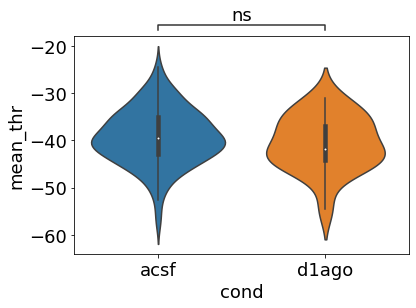

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. d1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.862e-02 U_stat=9.630e+02


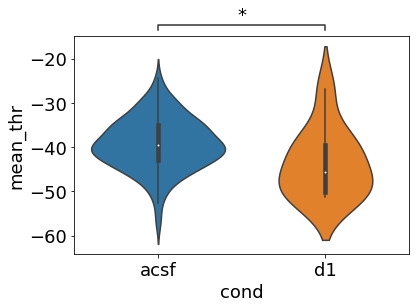

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. dopamine: Mann-Whitney-Wilcoxon test two-sided, P_val:7.337e-02 U_stat=8.310e+02


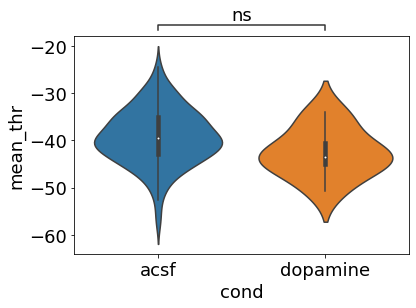

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ago: Mann-Whitney-Wilcoxon test two-sided, P_val:1.827e-01 U_stat=1.386e+03


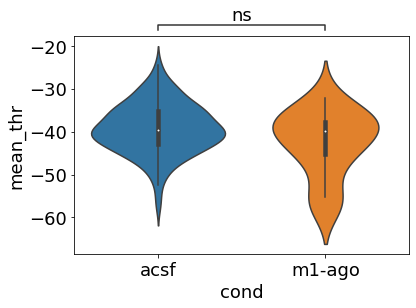

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ago+ant: Mann-Whitney-Wilcoxon test two-sided, P_val:1.485e-01 U_stat=2.210e+02


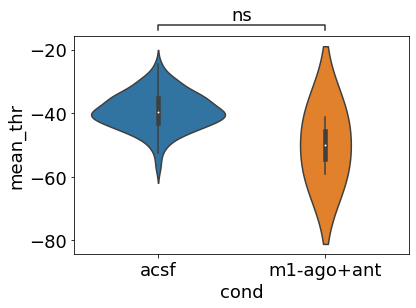

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. d2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-01 U_stat=9.990e+02


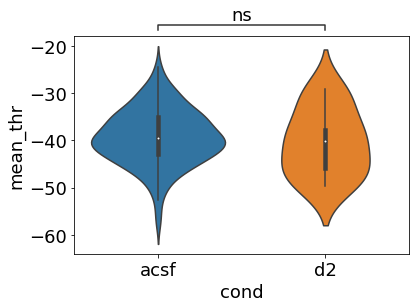

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. sag: Mann-Whitney-Wilcoxon test two-sided, P_val:3.345e-02 U_stat=9.550e+02


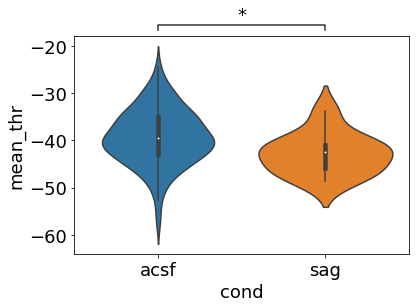

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ag: Mann-Whitney-Wilcoxon test two-sided, P_val:9.783e-01 U_stat=1.340e+02


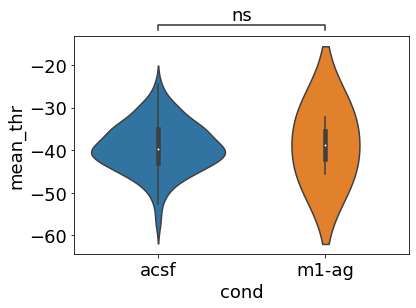

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. agoanta: Mann-Whitney-Wilcoxon test two-sided, P_val:2.576e-01 U_stat=1.500e+03


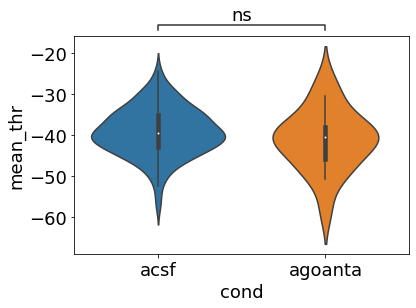

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant: Mann-Whitney-Wilcoxon test two-sided, P_val:6.297e-01 U_stat=8.140e+02


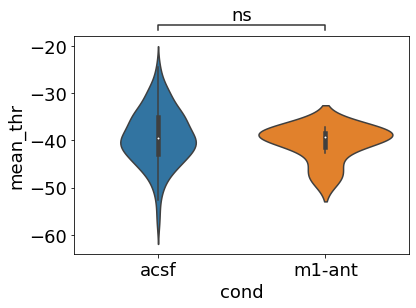

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. cirazoline: Mann-Whitney-Wilcoxon test two-sided, P_val:7.835e-02 U_stat=1.847e+03


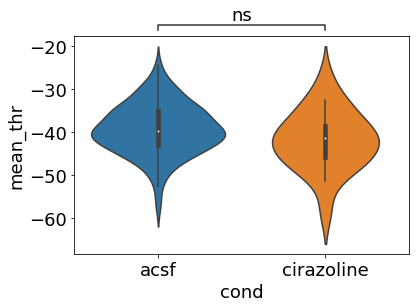

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:1.734e-01 U_stat=3.830e+02


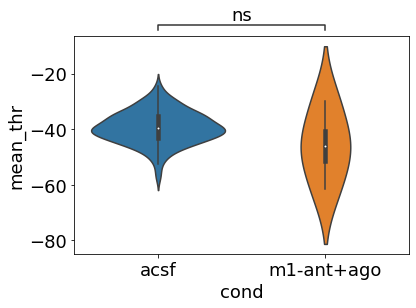

<ipython-input-250-d494d95d7c44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-250-d494d95d7c44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. dop: Mann-Whitney-Wilcoxon test two-sided, P_val:6.523e-03 U_stat=1.118e+03


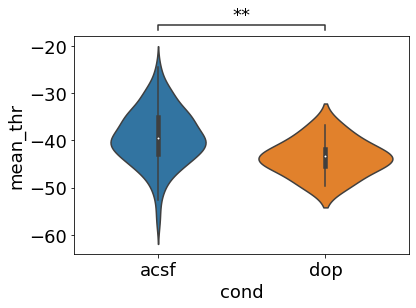

In [330]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
for drug in all_drug_FN:
    if drug !='acsf':
        plot_significance(df_inh_FN,drug,'mean_thr')

CC analysis


In [17]:
data_CC = pd.read_pickle("C:/Users/Nishant Joshi/Downloads/CC_files_all_experimenters_all_conditions.p")

np.unique(data_CC.cond,return_counts=True)

(array(['5HT-1f(S1 cortex)', '5HT1f(M1 cortex)', 'Alpha1', 'D1', 'D2',
        'M1', 'dopamine'], dtype=object),
 array([  8,  78,  78, 125,  20,  84,   4], dtype=int64))

In [60]:
df_cc = data_CC[~data_CC.waveforms.isna()]

df_cc.cond[~np.array(df_cc.drug,dtype=bool)] ='acsf'
df_cc_acsf=df_cc[df_cc.cond=='acsf']


<ipython-input-60-a00706b18925>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc.cond[~np.array(df_cc.drug,dtype=bool)] ='acsf'


2


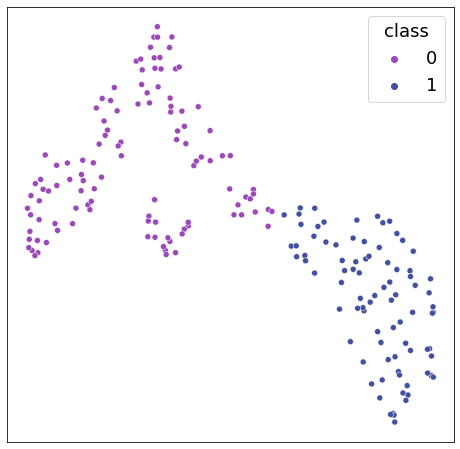

In [61]:
waves = normalize(np.vstack(df_cc_acsf['waveforms']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )

<ipython-input-62-36ab8570db5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_acsf['LV_ID'] =lables_wave


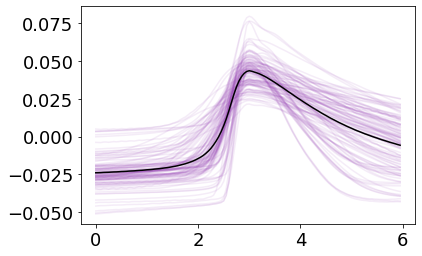

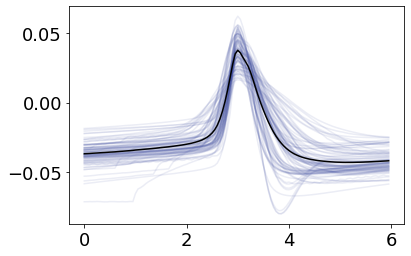

In [62]:
df_cc_acsf['LV_ID'] =lables_wave 


for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.vstack(df_cc_acsf[df_cc_acsf.LV_ID==i]['waveforms']).T
    plt.plot(np.arange(0,120/20,1/20),to_plot,c=coherence_colors[i],alpha=0.1)

    # plt.title('cluster '+str(i))
    plt.plot(np.arange(0,120/20,1/20),np.mean(np.vstack(df_cc_acsf[df_cc_acsf.LV_ID==i]['waveforms']).T,axis=1),c='black',alpha=1)
    plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='abs_firing_rate', ylabel='Density'>

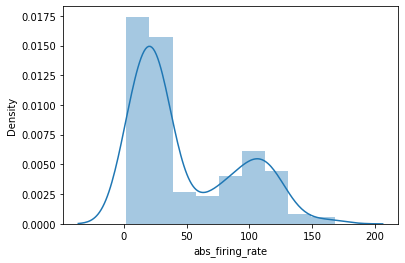

In [292]:
sns.distplot(df_cc['abs_firing_rate'])


In [64]:
exps_exc = df_cc_acsf[df_cc_acsf.LV_ID==0].exp_name
exps_inh = df_cc_acsf[df_cc_acsf.LV_ID==1].exp_name

df_exc_cc = df_cc[df_cc.exp_name.isin(exps_exc)]
df_inh_cc = df_cc[df_cc.exp_name.isin(exps_inh)]

In [65]:
all_drugs = set(df_inh_cc.cond)

In [66]:
print(np.unique(df_inh_cc.cond,return_counts=True))
print(np.unique(df_exc_cc.cond,return_counts=True))

pd.DataFrame({'Drug':np.unique(df_inh_cc.cond,return_counts=True)[0],'counts':np.unique(df_inh_cc.cond,return_counts=True)[1]})

(array(['5HT-1f(S1 cortex)', '5HT1f(M1 cortex)', 'Alpha1', 'D1', 'M1',
       'acsf'], dtype=object), array([ 1, 20, 22, 18, 19, 85], dtype=int64))
(array(['5HT-1f(S1 cortex)', '5HT1f(M1 cortex)', 'Alpha1', 'D1', 'D2',
       'M1', 'acsf', 'dopamine'], dtype=object), array([  1,  19,  16,  37,   5,  23, 112,   1], dtype=int64))


,Drug,counts
0,5HT-1f(S1 cortex),1
1,5HT1f(M1 cortex),20
2,Alpha1,22
3,D1,18
4,M1,19
5,acsf,85


In [68]:
df_inh_cc.columns

Index(['waveforms', 'current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'first_hwidths', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp', 'cond', 'drug', 'exp_name',
       'trialnr'],
      dtype='object')

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. M1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.129e-01 U_stat=8.440e+02


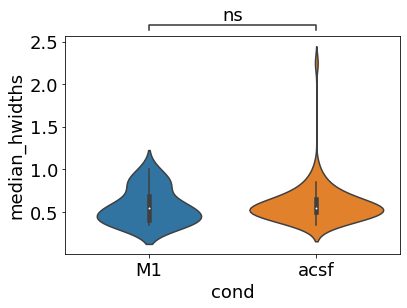

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. Alpha1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.850e-01 U_stat=9.165e+02


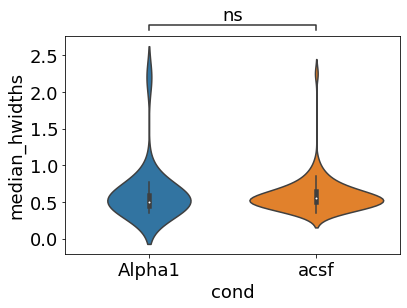

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.527e-01 U_stat=7.220e+02


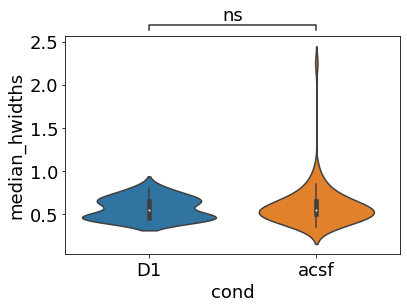

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): Mann-Whitney-Wilcoxon test two-sided, P_val:7.708e-01 U_stat=7.755e+02


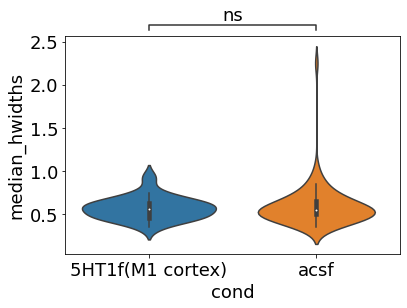

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): Mann-Whitney-Wilcoxon test two-sided, P_val:1.667e-01 U_stat=7.350e+01


<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


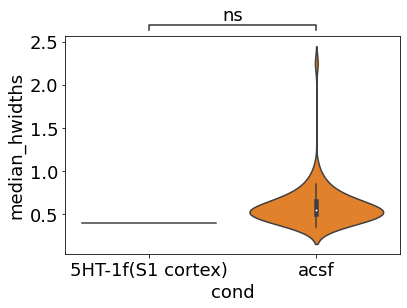

In [73]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
for drug in all_drugs:
    if drug !='acsf':
        plot_significance(df_inh_cc,drug,'median_hwidths')

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. M1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.161e-01 U_stat=3.255e+02


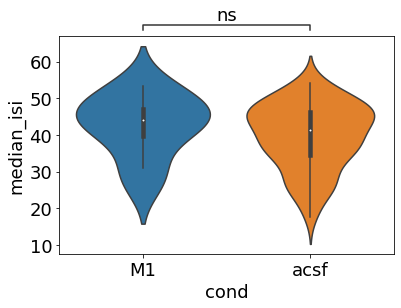

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. Alpha1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.909e-01 U_stat=1.100e+02


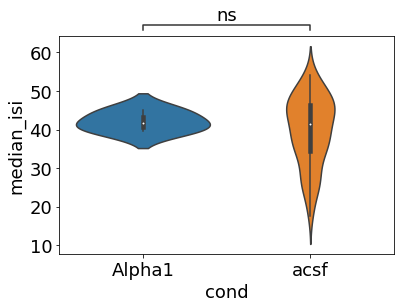

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.714e-01 U_stat=5.645e+02


<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


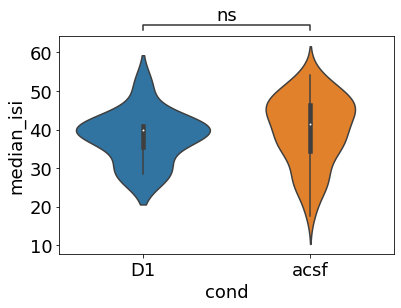

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): Mann-Whitney-Wilcoxon test two-sided, P_val:5.183e-01 U_stat=2.380e+02


<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


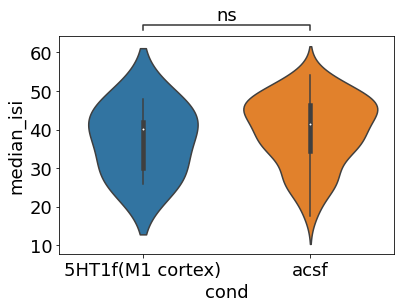

<ipython-input-36-95b7d5fc0804>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug.cond = pd.Categorical(df_drug['cond'])
<ipython-input-36-95b7d5fc0804>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug[var] = np.array(df_drug[var],dtype=np.float32)


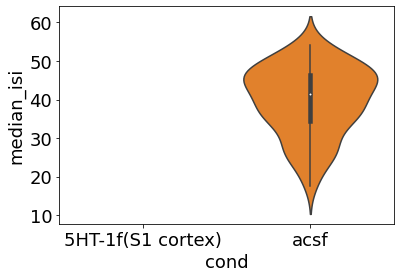

In [88]:
for drug in all_drugs:
    if drug !='acsf':
        try:
            plot_significance(df_exc_cc,drug,'median_isi')
        except:
            pass

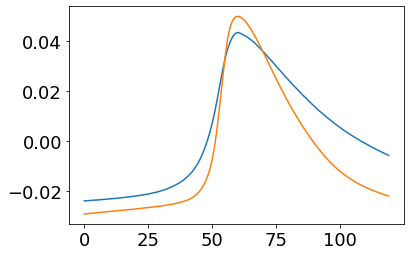

In [84]:
wave_acsf = np.mean(np.vstack(df_exc_cc[df_exc_cc.cond=='acsf']['waveforms']),axis=0)
wave_d1 = np.mean(np.vstack(df_exc_cc[df_exc_cc.cond=='D1']['waveforms']),axis=0)

plt.plot(wave_acsf.T)

plt.plot(wave_d1.T)